# Utilities

In [2]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

## EWS functions

In [3]:
def get_EWS(time,data,trend,ws):
    linfits = []
    ps = []
    bound = ws // 2
    
    std = runstd(data - trend, ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], std[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(std[:-2], 1000, p0))
    
    ar1 = runac(data - trend, ws)[bound : -bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-3], ar1[:-3], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(ar1[:-2], 1000, p0))
    
    lam = run_fit_a_ar1(data-trend,ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], lam[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(lam[:-2], 1000, p0))
    
    return std, ar1, lam, linfits, ps

In [4]:
def plot_EWS(data, timess, ws=70, col='k',lbl='',alph=1,lw=1):
    bound = ws // 2
#     popt, cov = curve_fit(funcfit3, timess, data, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
#     trend = funcfit3(timess, *popt)
    trend = gaussian_filter1d(data, 10)

    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    ax1.plot(timess[bound : -bound],std,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(std[:-2],1000,linfits[1][0])
    ax1.plot(timess[bound : -bound][:-2],linfits[0][0] * timess[bound : -bound][:-2] + linfits[0][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax2.plot(timess[bound : -bound],ar1,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(ar1[:-2],1000,linfits[1][0])
    ax2.plot(timess[bound : -bound][:-2],linfits[1][0] * timess[bound : -bound][:-2] + linfits[1][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=alph,lw=lw)
    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope
#     ax3.plot(timess[bound : -bound][:-2], p0 * timess[bound : -bound][:-2]**2+p1 * timess[bound : -bound][:-2] + p2, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))
    ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

# Get Data

In [5]:
ds = xr.open_dataset('CMIP6_amoc.nc')

In [6]:
strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index

In [7]:
strn26.load()
strn35.load()
index.load()

<xarray.DataArray 'index' (models: 34, ensemble_members: 10, year: 165)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -9.83567818,  -9.96747804,  -9.87559962, ...,  -9.8192265 ,
          -9.53018165,  -9.60423207],
        [ -9.26724124,  -9.20765185,  -9.62124856, ..., -10.28693318,
         -10.51233848, -10.22079849],
        [ -9.45160929,  -9.45961754,  -9.54747669, ..., -10.22823318,
         -10.1423463 ,  -9.9231437 ],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -8.9466881 ,  -9.2422324 ,  -9.27880526, ...,  -9.5742743 ,
          -9.38110113,  -9.47151629],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * models            (models) object 'AWI-CM-1-1-MR' ... 'SAM0-UNICON'
  * year              (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
  * ensemble_members  (ensemble_members) object 'r1i1p1f1' ... 'r10i1p1f1'

limit_output extension: Maximum message size of 10000 exceeded with 18219 characters

In [8]:
yrs = strn26.year.values
models = strn26.models.values
ensembs = strn26.ensemble_members.values

# Detrending

Choose a gaussian filter with sigma of **10**

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


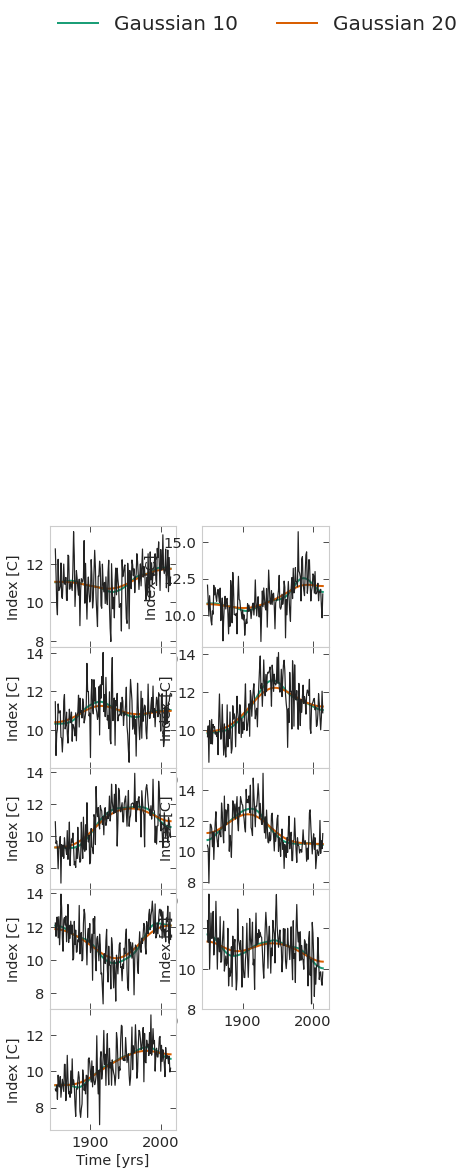

In [9]:
ws = 70
bound = ws // 2
ens_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
model = 'GISS-E2-1-G'
model = 'IPSL-CM6A-LR'
%matplotlib inline
fig = plt.figure(figsize = (5,20))
for i in range(9):
    ax = fig.add_subplot(921+i)
    # col = ens_colors[i]
    col = 'C0'
    amoc = np.nan_to_num(strn26.sel(models=model).isel(ensemble_members=i).values)
    yrs = strn26.year.values

    if np.sum(amoc) != 0:
        trend = gaussian_filter1d(amoc, 10)
        plt.plot(yrs,trend,color='C0',linestyle='-',label='Gaussian 10',lw=2)
        
        trend = gaussian_filter1d(amoc, 20)
        plt.plot(yrs,trend,color='C1',linestyle='-',label='Gaussian 20',lw=2)
        
#         popt, cov = curve_fit(funcfit3, yrs, amoc, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
#         trend = funcfit3(yrs, *popt)
#         plt.plot(yrs,trend,color='C2',linestyle='-',label='1/3 power fit',lw=2)
        
        plt.plot(yrs, amoc,color='k')
        
    plt.ylabel('Index [C]')
plt.xlabel('Time [yrs]')
fig.subplots_adjust(hspace=0)
ax.legend(bbox_to_anchor=(0, 9.3), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=5)
plt.show()

# Some plots

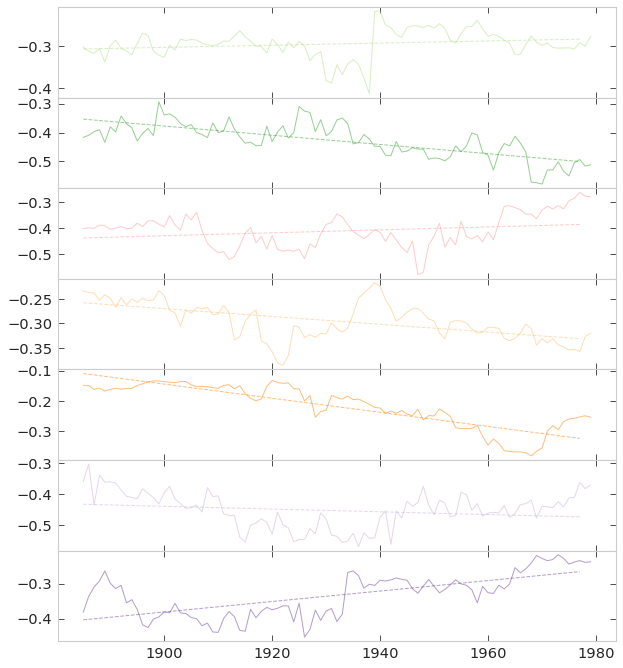

In [10]:
ws = 70
bound = ws // 2

fig = plt.figure(figsize=(10,15))

model = 'GISS-E2-1-G'
ens_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
j=0
for i in range(10):
    data = np.nan_to_num(strn26.sel(models=model).isel(ensemble_members=i).values)
    timess = strn26.year.values
    trend = gaussian_filter1d(data, 10)
    lbl = ensembs[i]
    col = ens_colors[i]

    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope

    if pv>0.05:
        ax3 = fig.add_subplot(911+j)
        ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=0.5,lw=1)
        ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=0.5,lw=1,label="p = {:.3f}".format(pv))
        j = j+1
fig.subplots_adjust(hspace=0)
plt.show()

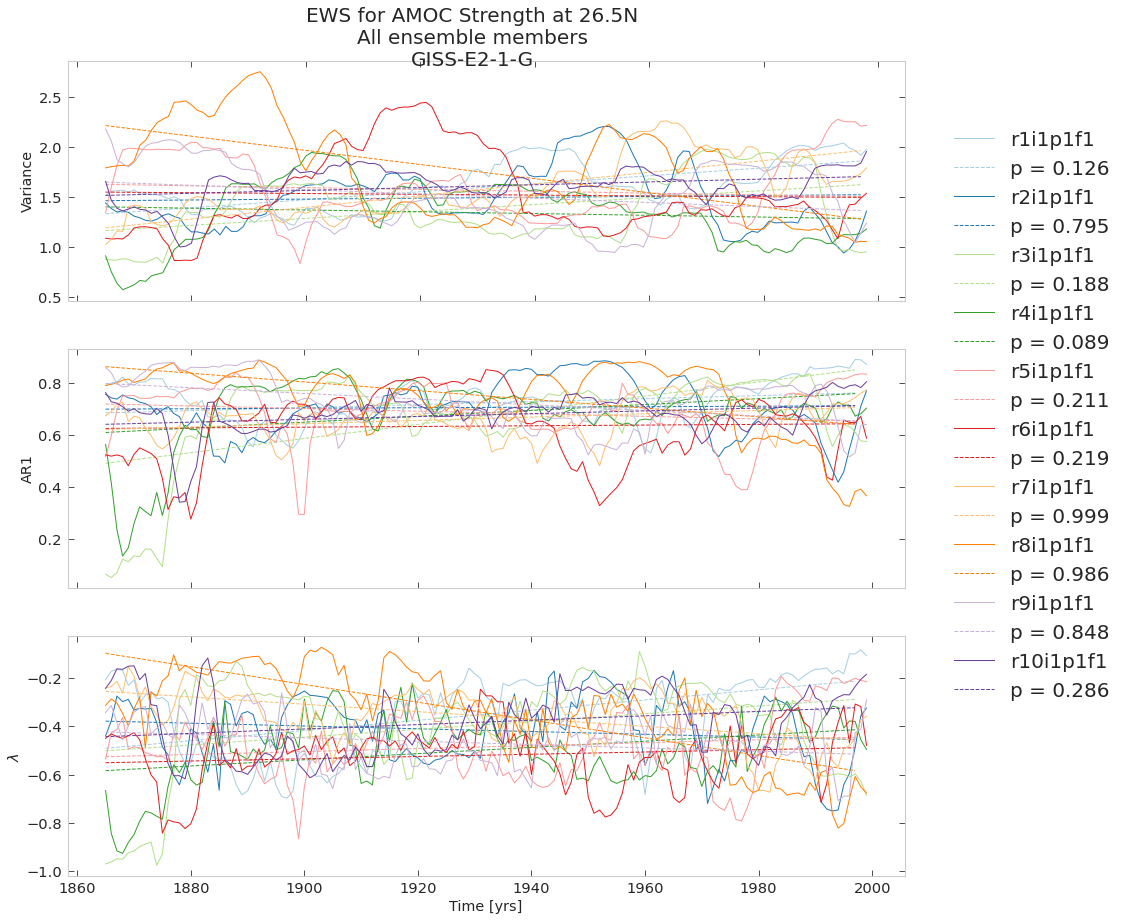

In [11]:
ws = 30
bound = ws // 2

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))

model = 'GISS-E2-1-G'
ens_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

for i in range(10):
    amoc = np.nan_to_num(strn26.sel(models=model).isel(ensemble_members=i).values)
    yrs = strn26.year.values
    
    if np.sum(amoc) != 0:

        plot_EWS(amoc,yrs,ws=ws,col=ens_colors[i],lbl=ensembs[i])

ax1.set_ylabel('Variance')
# ax1.legend(bbox_to_anchor=(1.05, -1), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_ylabel('AR1')
# ax2.legend(bbox_to_anchor=(1.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax3.set_ylabel('$\lambda$')
ax3.legend(bbox_to_anchor=(1.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax3.set_xlabel('Time [yrs]')

fig.suptitle('EWS for AMOC Strength at 26.5N\nAll ensemble members\n{}'.format(model),fontsize=20, y=0.93)
plt.show()

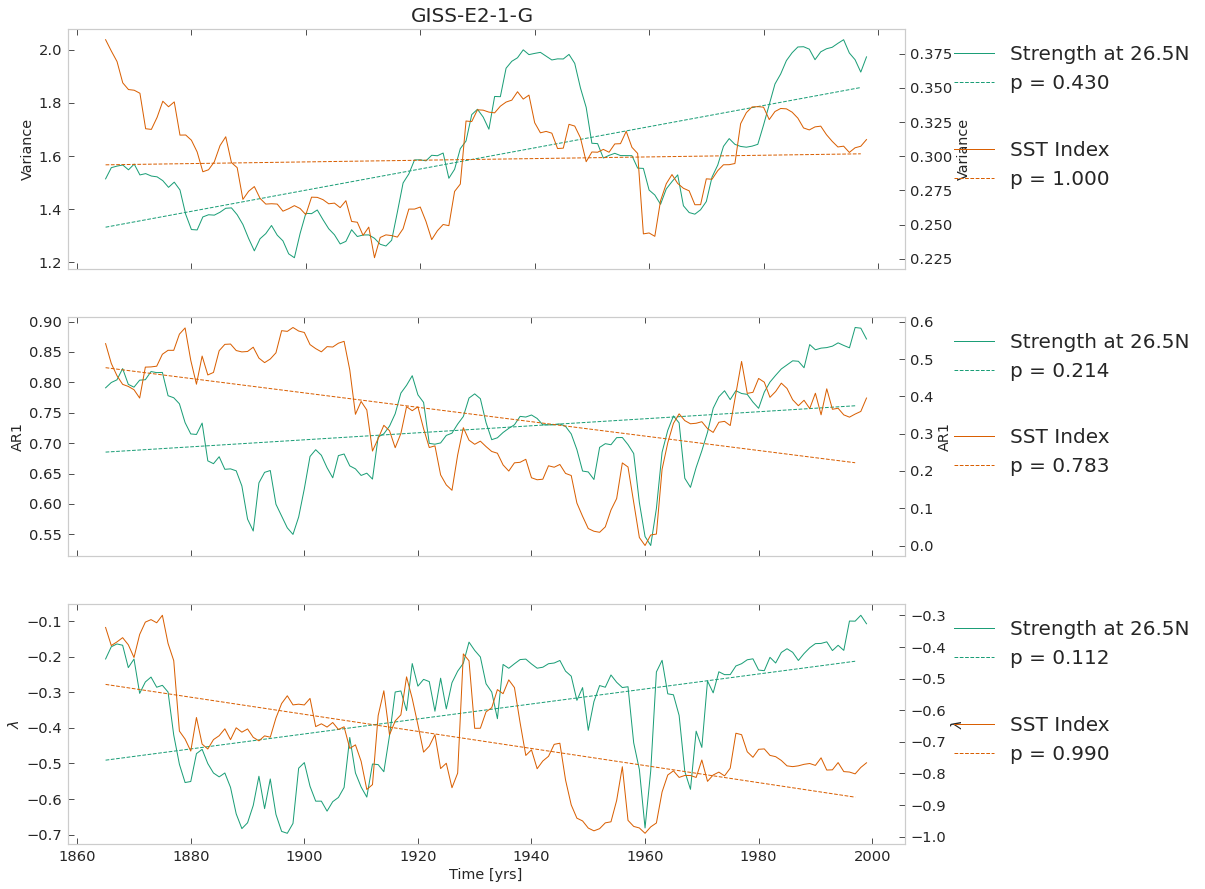

In [12]:
ws = 30
bound = ws // 2

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))

model = 'GISS-E2-1-G'
i = 0
ens_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

amoc = np.nan_to_num(strn26.sel(models=model).isel(ensemble_members=i).values)
yrs = strn26.year.values
plot_EWS(amoc,yrs,ws=ws,col='C0',lbl='Strength at 26.5N')

ax1.set_ylabel('Variance')
ax1.legend(bbox_to_anchor=(1.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_ylabel('AR1')
ax2.legend(bbox_to_anchor=(1.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax3.set_ylabel('$\lambda$')
ax3.legend(bbox_to_anchor=(1.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax3.set_xlabel('Time [yrs]')

ax1 = ax1.twinx()
ax2 = ax2.twinx()
ax3 = ax3.twinx()
amoc = np.nan_to_num(index.sel(models=model).isel(ensemble_members=i).values)
yrs = index.year.values
plot_EWS(amoc,yrs,ws=ws,col='C1',lbl='SST Index')

ax1.set_ylabel('Variance')
ax1.legend(bbox_to_anchor=(1.05, 0.3), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax1.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax2.set_ylabel('AR1')
ax2.legend(bbox_to_anchor=(1.05, 0.3), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax2.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
ax3.set_ylabel('$\lambda$')
ax3.legend(bbox_to_anchor=(1.05, 0.3), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax3.set_xlabel('Time [yrs]')

fig.suptitle(model,fontsize=20, y=0.9)
plt.show()

# Make EWS files

In [13]:
def make_lambda_array(data,ws=70,gedge=5):
    lambdas = np.full((data.shape[0],data.shape[1],data.shape[2]-2*gedge),np.nan)
    for i in np.arange(0,data.shape[0]):
        for j in np.arange(0,data.shape[1]):
            amoc = np.nan_to_num(data[i,j].values)
            amoc_low = gaussian_filter1d(amoc, 10)
            if amoc.sum() != 0:
                lamb = run_fit_a_ar1((amoc-amoc_low)[gedge:-gedge],ws)
                lambdas[i,j,:]=lamb
    return lambdas

In [14]:
def make_pvs_array(lambdas,time,ws=70):
    bound = ws // 2
    tt = time[bound:-bound]
    lambda_pvs = np.full((lambdas.shape[0],lambdas.shape[1]),np.nan)
    for i in np.arange(0,lambdas.shape[0]):
        for j in np.arange(0,lambdas.shape[1]):
            lam = np.nan_to_num(lambdas[i,j,:][bound : -bound].values)
            if lam.sum() != 0:
                p0, p1 = np.polyfit(tt[:-2], lam[:-2], 1)
                pv = kendall_tau_test(lam[:-2], 10000, p0)
                lambda_pvs[i,j]=pv
    return lambda_pvs

In [15]:
def make_lambda_trend_array(lambdas,time,ws=70):
    bound = ws // 2
    tt = time[bound:-bound]
    lambda_trends = np.full((lambdas.shape[0],lambdas.shape[1]),np.nan)
    for i in np.arange(0,lambdas.shape[0]):
        for j in np.arange(0,lambdas.shape[1]):
            lam = np.nan_to_num(lambdas[i,j,:][bound : -bound].values)
            if lam.sum() != 0:
                p0, p1 = np.polyfit(tt[:-2], lam[:-2], 1)
                lambda_trends[i,j]=p0
    return lambda_trends

## lambda

In [16]:
# strn26_lambda = make_lambda_array(strn26)
# strn35_lambda = make_lambda_array(strn35)
# index_lambda = make_lambda_array(index)
# lambdas = xr.Dataset(
#     data_vars = dict(index_lambda=(['models','ensemble_members','time'],index_lambda),
#                      strn35_lambda=(['models','ensemble_members','time'],strn35_lambda),
#                      strn26_lambda=(['models','ensemble_members','time'],strn26_lambda)),
#     coords = dict(
#             time = xr.DataArray(index.year[5:-5].values, dims="time", coords=dict(time=("time", index.year[5:-5].values))),
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Lambda for amoc strengths and index.\n Detrending: gaussian filter with sigma of 10 (5 yrs removed on each side)\n Window size 70 yrs')
# )
# lambdas.to_netcdf('EWS_files/CMIP6_lambdas.nc')

In [17]:
# strn26_lambda = make_lambda_array(strn26, ws=30)
# strn35_lambda = make_lambda_array(strn35, ws=30)
# index_lambda = make_lambda_array(index, ws=30)
# lambdas = xr.Dataset(
#     data_vars = dict(index_lambda=(['models','ensemble_members','time'],index_lambda),
#                      strn35_lambda=(['models','ensemble_members','time'],strn35_lambda),
#                      strn26_lambda=(['models','ensemble_members','time'],strn26_lambda)),
#     coords = dict(
#             time = xr.DataArray(index.year[5:-5].values, dims="time", coords=dict(time=("time", index.year[5:-5].values))),
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Lambda for amoc strengths and index.\n Detrending: gaussian filter with sigma of 10 (5 yrs removed on each side)\n Window size 30 yrs')
# )
# lambdas.to_netcdf('EWS_files/CMIP6_lambdas_w30.nc')

## trends and pvs of linear trend

In [18]:
# lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas.nc')
# strn26_pvs = make_pvs_array(lambdas.strn26_lambda,lambdas.time)
# strn35_pvs = make_pvs_array(lambdas.strn35_lambda,lambdas.time)
# index_pvs = make_pvs_array(lambdas.index_lambda,lambdas.time)
# lambda_pvs = xr.Dataset(
#     data_vars = dict(index_pvs=(['models','ensemble_members'],index_pvs),
#                      strn35_pvs=(['models','ensemble_members'],strn35_pvs),
#                      strn26_pvs=(['models','ensemble_members'],strn26_pvs)),
#     coords = dict(
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Kendall Tau test P for lambdas of amoc strengths and index.\n Using 10000 fourier surrogates')
# )
# lambda_pvs.to_netcdf('EWS_files/CMIP6_lambda_pvs.nc')

In [19]:
import scipy.stats as st
def make_kendall_array(lambdas,time,ws=70):
    bound = ws // 2
    tt = time[bound:-bound]
    lambda_taus = np.full((lambdas.shape[0],lambdas.shape[1]),np.nan)
    lambda_pvs = np.full((lambdas.shape[0],lambdas.shape[1]),np.nan)
    for i in np.arange(0,lambdas.shape[0]):
        for j in np.arange(0,lambdas.shape[1]):
            lam = np.nan_to_num(lambdas[i,j,:][bound : -bound])
            if lam.sum() != 0:
                tau = st.kendalltau(tt,lam)
                lambda_pvs[i,j]=tau[1]
                lambda_taus[i,j]=tau[0]
    return lambda_pvs, lambda_taus

In [20]:
lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas.nc')
strn26_pvs, strn26_taus = make_kendall_array(lambdas.strn26_lambda.values,lambdas.time.values)
strn35_pvs, strn35_taus = make_kendall_array(lambdas.strn35_lambda.values,lambdas.time.values)
index_pvs, index_taus = make_kendall_array(lambdas.index_lambda.values,lambdas.time.values)

lambda_taus = xr.Dataset(
    data_vars = dict(index_pvs=(['models','ensemble_members'],index_taus),
                     strn35_pvs=(['models','ensemble_members'],strn35_taus),
                     strn26_pvs=(['models','ensemble_members'],strn26_taus)),
    coords = dict(
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Kendall Tau test P for lambdas of amoc strengths and index.')
)
lambda_taus.to_netcdf('EWS_files/CMIP6_lambda_kendall_taus_old.nc')

In [21]:
lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas_w30.nc')
strn26_pvs, strn26_taus = make_kendall_array(lambdas.strn26_lambda.values,lambdas.time.values)
strn35_pvs, strn35_taus = make_kendall_array(lambdas.strn35_lambda.values,lambdas.time.values)
index_pvs, index_taus = make_kendall_array(lambdas.index_lambda.values,lambdas.time.values)

lambda_taus_w30 = xr.Dataset(
    data_vars = dict(index_pvs=(['models','ensemble_members'],index_taus),
                     strn35_pvs=(['models','ensemble_members'],strn35_taus),
                     strn26_pvs=(['models','ensemble_members'],strn26_taus)),
    coords = dict(
            models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
            ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
    attrs = dict(
    description='Kendall Tau test P for lambdas of amoc strengths and index.')
)
lambda_taus_w30.to_netcdf('EWS_files/CMIP6_lambda_kendall_taus_old_w30.nc')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


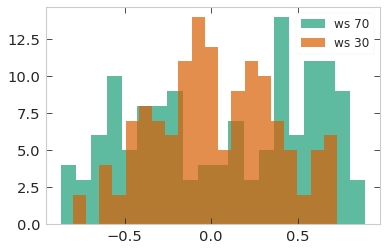

In [22]:
# lambda_taus = xr.open_dataset('EWS_files/CMIP6_lambda_kendall_taus_new.nc')
data = lambda_taus.strn35_pvs
plt.hist(data.values.ravel(),bins=20,alpha=0.7,label='ws 70')
data = lambda_taus_w30.strn35_pvs
plt.hist(data.values.ravel(),bins=20,alpha=0.7,label='ws 30')
plt.legend()
plt.show()

In [23]:
# lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas_w30.nc')
# strn26_pvs = make_pvs_array(lambdas.strn26_lambda,lambdas.time,ws=30)
# strn35_pvs = make_pvs_array(lambdas.strn35_lambda,lambdas.time,ws=30)
# index_pvs = make_pvs_array(lambdas.index_lambda,lambdas.time,ws=30)
# lambda_pvs = xr.Dataset(
#     data_vars = dict(index_pvs=(['models','ensemble_members'],index_pvs),
#                      strn35_pvs=(['models','ensemble_members'],strn35_pvs),
#                      strn26_pvs=(['models','ensemble_members'],strn26_pvs)),
#     coords = dict(
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Kendall Tau test P for lambdas of amoc strengths and index.\n Using 10000 fourier surrogates')
# )
# lambda_pvs.to_netcdf('EWS_files/CMIP6_lambda_pvs_w30.nc')

In [24]:
# lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas.nc')
# strn26_trends = make_lambda_trend_array(lambdas.strn26_lambda,lambdas.time)
# strn35_trends = make_lambda_trend_array(lambdas.strn35_lambda,lambdas.time)
# index_trends = make_lambda_trend_array(lambdas.index_lambda,lambdas.time)
# lambda_trends = xr.Dataset(
#     data_vars = dict(index_trends=(['models','ensemble_members'],index_trends),
#                      strn35_trends=(['models','ensemble_members'],strn35_trends),
#                      strn26_trends=(['models','ensemble_members'],strn26_trends)),
#     coords = dict(
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Linear slope for lambdas of amoc strengths and index.')
    
# )
# lambda_trends.to_netcdf('EWS_files/CMIP6_lambda_trends.nc')

# Analysis

In [25]:
lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas.nc')
lambda_pvs = xr.open_dataset('EWS_files/CMIP6_lambda_pvs.nc')
lambda_trends = xr.open_dataset('EWS_files/CMIP6_lambda_trends.nc')

In [26]:
min_pv = 0.05

EWS_all = lambda_pvs.where(
           ((lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.strn35_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv)))
EWS_strn26 = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv))
EWS_strn35 = lambda_pvs.where(
           (lambda_pvs.strn35_pvs<=min_pv))
EWS_index = lambda_pvs.where(
           (lambda_pvs.index_pvs<=min_pv))

EWS_any = lambda_pvs.where(
           ((lambda_pvs.strn26_pvs<=min_pv) |
            (lambda_pvs.strn35_pvs<=min_pv) |
            (lambda_pvs.index_pvs<=min_pv)))
EWS_strns = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.strn35_pvs<=min_pv))
EWS_strn35indx = lambda_pvs.where(
           (lambda_pvs.strn35_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv))
EWS_strn26indx = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv))

In [27]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_autopct

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


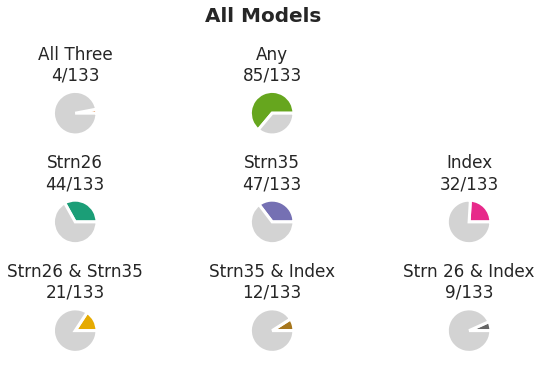

In [28]:
N_tot = np.count_nonzero(~np.isnan(lambda_pvs.strn26_pvs.values))
N_all = np.count_nonzero(~np.isnan(EWS_all.strn26_pvs.values))
N_s26 = np.count_nonzero(~np.isnan(EWS_strn26.strn26_pvs.values))
N_s35 = np.count_nonzero(~np.isnan(EWS_strn35.strn26_pvs.values))
N_indx = np.count_nonzero(~np.isnan(EWS_index.strn26_pvs.values))
N_any = np.count_nonzero(~np.isnan(EWS_any.strn26_pvs.values))
N_strns = np.count_nonzero(~np.isnan(EWS_strns.strn26_pvs.values))
N_strn35indx = np.count_nonzero(~np.isnan(EWS_strn35indx.strn26_pvs.values))
N_strn26indx = np.count_nonzero(~np.isnan(EWS_strn26indx.strn26_pvs.values))

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[0,0])
data = [N_all,N_tot-N_all]
patches, texts= ax.pie(
data,
    colors = ['C1','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('All Three\n{}/{}'.format(N_all,N_tot))

ax = fig.add_subplot(gs[0,1])
data = [N_any,N_tot-N_any]
patches, texts= ax.pie(
data,
    colors = ['C4','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Any\n{}/{}'.format(N_any,N_tot))

ax = fig.add_subplot(gs[1,0])
data = [N_s26,N_tot-N_s26]
patches, texts= ax.pie(
data,
colors = ['C0','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn26\n{}/{}'.format(N_s26,N_tot))

ax = fig.add_subplot(gs[1,1])
data = [N_s35,N_tot-N_s35]
patches, texts= ax.pie(
data,
    colors = ['C2','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn35\n{}/{}'.format(N_s35,N_tot))

ax = fig.add_subplot(gs[1,2])
data = [N_indx,N_tot-N_indx]
patches, texts= ax.pie(
data,
    colors = ['C3','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Index\n{}/{}'.format(N_indx,N_tot))



ax = fig.add_subplot(gs[2,0])
data = [N_strns,N_tot-N_strns]
patches, texts= ax.pie(
data,
colors = ['C5','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn26 & Strn35\n{}/{}'.format(N_strns,N_tot))

ax = fig.add_subplot(gs[2,1])
data = [N_strn35indx,N_tot-N_strn35indx]
patches, texts= ax.pie(
data,
    colors = ['C6','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn35 & Index\n{}/{}'.format(N_strn35indx,N_tot))

ax = fig.add_subplot(gs[2,2])
data = [N_strn26indx,N_tot-N_strn26indx]
patches, texts= ax.pie(
data,
    colors = ['C7','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Strn 26 & Index\n{}/{}'.format(N_strn26indx,N_tot))


fig.subplots_adjust(hspace=1)
fig.suptitle('All Models',fontsize=20,fontweight='bold',y=1.1)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


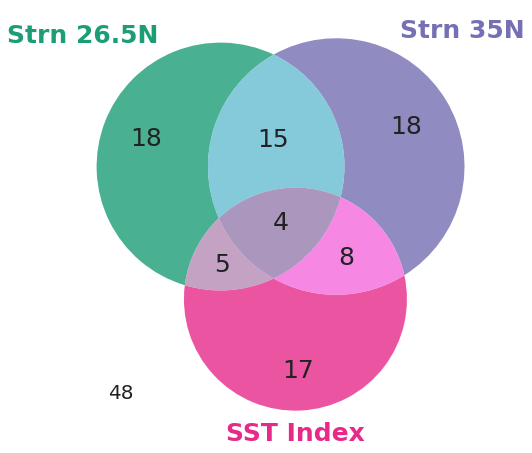

In [29]:
from matplotlib_venn import venn3, venn3_circles
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
subsets = (18, 18, 15, 17, 5, 8, 4)
cols = ['C0','C2','C3']
out = venn3(subsets = subsets, set_labels = ('Strn 26.5N', 'Strn 35N', 'SST Index'), alpha = 0.8,set_colors=['C0','C2','C3'])
# venn3_circles(subsets = subsets)
for i, text in enumerate(out.set_labels):
    text.set_fontsize(25)
    text.set_fontweight('bold')
    text.set_color(cols[i])
for text in out.subset_labels:
    text.set_fontsize(25)
    text.set_color('k')
ax.text(0.1,0.1,48,transform=ax.transAxes,ma='left',color='k',fontsize=20)
fig.patch.set_facecolor("white")
plt.show()

In [30]:
# radius_one = 0.3
# for modls in [models[0:17],models[17:]]:
#     fig = plt.figure(figsize=(25,5))
#     gs = fig.add_gridspec(4, 15)
#     ir = 0

#     for im, model in enumerate(modls):
#         n_tot = np.count_nonzero(~np.isnan(lambda_pvs.strn26_pvs.sel(models=model).values))
#         n_all = np.count_nonzero(~np.isnan(EWS_all.strn26_pvs.sel(models=model).values))
#         n_s26 = np.count_nonzero(~np.isnan(EWS_strn26.strn26_pvs.sel(models=model).values))
#         n_s35 = np.count_nonzero(~np.isnan(EWS_strn35.strn26_pvs.sel(models=model).values))
#         n_indx = np.count_nonzero(~np.isnan(EWS_index.strn26_pvs.sel(models=model).values))

#         radius = 0.3+0.4*np.sqrt(n_tot)

#         if n_tot!= 0:

#             ax = fig.add_subplot(gs[0,ir])
#             data = [n_all,n_tot-n_all]
#             patches, texts= ax.pie(
#             data,
#                 radius = radius,
#                 colors = ['C1','lightgrey'],
#             wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
#             textprops={'size': 'x-large'})
#             ax.set_title('{}\n{}'.format(model,n_tot),fontsize=10,fontweight='bold',y=1.1)


#             ax = fig.add_subplot(gs[1,ir])
#             data = [n_s26,n_tot-n_s26]
#             patches, texts= ax.pie(
#             data,
#                 radius = radius,
#             colors = ['C0','lightgrey'],
#             wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
#             textprops={'size': 'x-large'})

#             ax = fig.add_subplot(gs[2,ir])
#             data = [n_s35,n_tot-n_s35]
#             patches, texts= ax.pie(
#             data,
#                 radius = radius,
#                 colors = ['C2','lightgrey'],
#             wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
#             textprops={'size': 'x-large'})

#             ax = fig.add_subplot(gs[3,ir])
#             data = [n_indx,n_tot-n_indx]
#             patches, texts= ax.pie(
#             data,
#                 radius = radius,
#                 colors = ['C3','lightgrey'],
#             wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
#             textprops={'size': 'x-large'})
#             if ir==0:
#                 ax.text(-1,3.6,'All',transform=ax.transAxes,fontweight='bold',ma='left',color='C1')
#                 ax.text(-1,2.6,'Strn26',transform=ax.transAxes,fontweight='bold',ma='left',color='C0')
#                 ax.text(-1,1.6,'Strn35',transform=ax.transAxes,fontweight='bold',ma='left',color='C2')
#                 ax.text(-1,0.6,'Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3')

#             ir = ir +1


#     fig.subplots_adjust(hspace=0)
# #     fig.tight_layout()
#     plt.show()

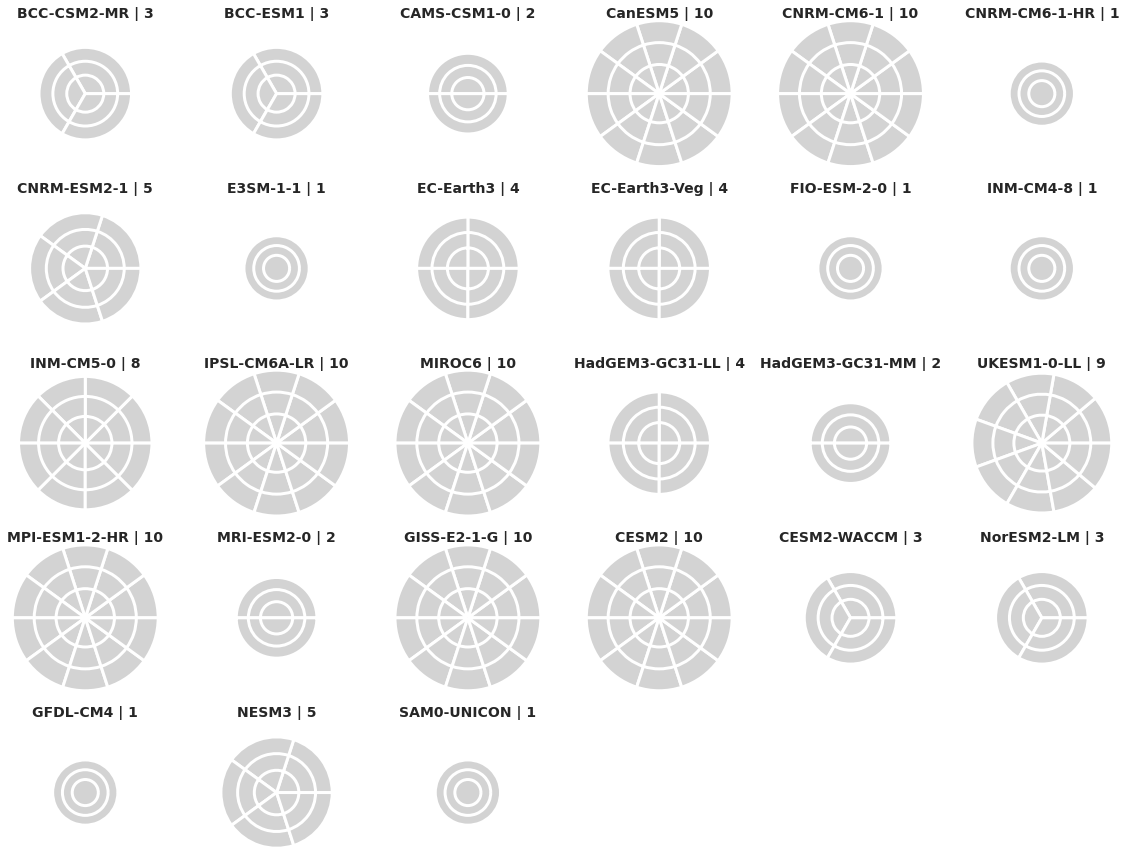

In [38]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(5, 6)
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(lambda_pvs.strn26_pvs.sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(lambda_pvs.strn26_pvs.sel(models=model).values))
#         n_all = np.count_nonzero(~np.isnan(EWS_all.strn26_pvs.sel(models=model).values))
#         n_s26 = np.count_nonzero(~np.isnan(EWS_strn26.strn26_pvs.sel(models=model).values))
#         n_s35 = np.count_nonzero(~np.isnan(EWS_strn35.strn26_pvs.sel(models=model).values))
#         n_indx = np.count_nonzero(~np.isnan(EWS_index.strn26_pvs.sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        colorss = ['C0','C2','C3']
        rads = [1,0.7,0.4]
        datass = [EWS_strn26.strn26_pvs,EWS_strn35.strn35_pvs,EWS_index.index_pvs]
        
        for i, datas in enumerate(datass):
            data = (~np.isnan(datas.sel(models=model).values[idc]))*1
            slices = np.full(len(data),1)
            idc2 = np.where(data==1)
            cols = np.full(len(data),'lightgrey')
#             cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


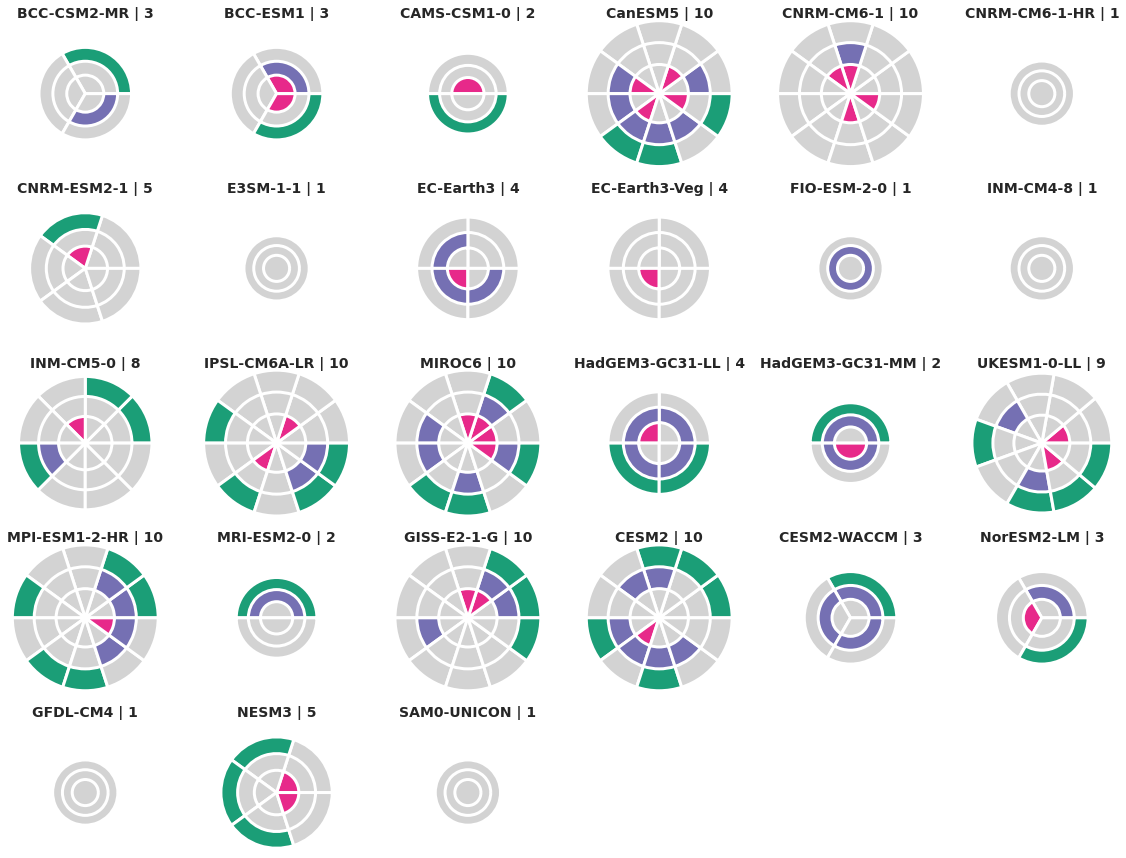

In [31]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(5, 6)
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(lambda_pvs.strn26_pvs.sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(lambda_pvs.strn26_pvs.sel(models=model).values))
#         n_all = np.count_nonzero(~np.isnan(EWS_all.strn26_pvs.sel(models=model).values))
#         n_s26 = np.count_nonzero(~np.isnan(EWS_strn26.strn26_pvs.sel(models=model).values))
#         n_s35 = np.count_nonzero(~np.isnan(EWS_strn35.strn26_pvs.sel(models=model).values))
#         n_indx = np.count_nonzero(~np.isnan(EWS_index.strn26_pvs.sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        colorss = ['C0','C2','C3']
        rads = [1,0.7,0.4]
        datass = [EWS_strn26.strn26_pvs,EWS_strn35.strn35_pvs,EWS_index.index_pvs]
        
        for i, datas in enumerate(datass):
            data = (~np.isnan(datas.sel(models=model).values[idc]))*1
            slices = np.full(len(data),1)
            idc2 = np.where(data==1)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


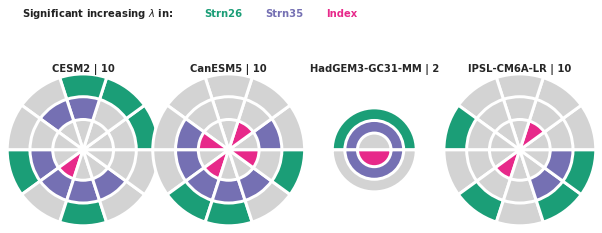

In [32]:
hosing_models = ['CESM2','CanESM5','HadGEM3-GC31-MM','IPSL-CM6A-LR']
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1, 4)
ir = 0

for im, model in enumerate(hosing_models):
    idc = np.where(~np.isnan(lambda_pvs.strn26_pvs.sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(lambda_pvs.strn26_pvs.sel(models=model).values))
#         n_all = np.count_nonzero(~np.isnan(EWS_all.strn26_pvs.sel(models=model).values))
#         n_s26 = np.count_nonzero(~np.isnan(EWS_strn26.strn26_pvs.sel(models=model).values))
#         n_s35 = np.count_nonzero(~np.isnan(EWS_strn35.strn26_pvs.sel(models=model).values))
#         n_indx = np.count_nonzero(~np.isnan(EWS_index.strn26_pvs.sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=8:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=9) & (ir<=17):
            ax = fig.add_subplot(gs[1,ir-9])
        if ir>=18:
            ax = fig.add_subplot(gs[2,ir-18])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=10,fontweight='bold',y=1.1)

        col = 'C0'
        data = (~np.isnan(EWS_strn26.strn26_pvs.sel(models=model).values[idc]))*1
        slices = np.full(len(data),1)
        idc2 = np.where(data==1)
        cols = np.full(len(data),'lightgrey')
        cols[idc2] = col
        patches, texts= ax.pie(
        slices,
            radius = radius,
        colors = cols,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        textprops={'size': 'x-large'})

        col = 'C2'
        data = (~np.isnan(EWS_strn35.strn35_pvs.sel(models=model).values[idc]))*1
        slices = np.full(len(data),1)
        idc2 = np.where(data==1)
        cols = np.full(len(data),'lightgrey')
        cols[idc2] = col
        patches, texts= ax.pie(
        slices,
            radius = radius-radius*0.3,
            colors = cols,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        textprops={'size': 'x-large'})

        col = 'C3'
        data = (~np.isnan(EWS_index.index_pvs.sel(models=model).values[idc]))*1
        slices = np.full(len(data),1)
        idc2 = np.where(data==1)
        cols = np.full(len(data),'lightgrey')
        cols[idc2] = col
        patches, texts= ax.pie(
        slices,
            radius = radius-radius*0.6,
            colors = cols,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        textprops={'size': 'x-large'})

        ir = ir +1
        
        if ir==1:
            ax.text(0,1.6,'Significant increasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(1.5,1.6,'Strn26',transform=ax.transAxes,fontweight='bold',ma='left',color='C0')
            ax.text(2,1.6,'Strn35',transform=ax.transAxes,fontweight='bold',ma='left',color='C2')
            ax.text(2.5,1.6,'Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3')
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

# Compare to trend

In [33]:
strn26_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn26.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn26_trend[imod,iens]=slope*100 # trend of Sv/century
index_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        idx = np.nan_to_num(index.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, idx)
        index_trend[imod,iens]=slope*100 # trend of Sv/century
strn35_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn35.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn35_trend[imod,iens]=slope*100 # trend of Sv/century

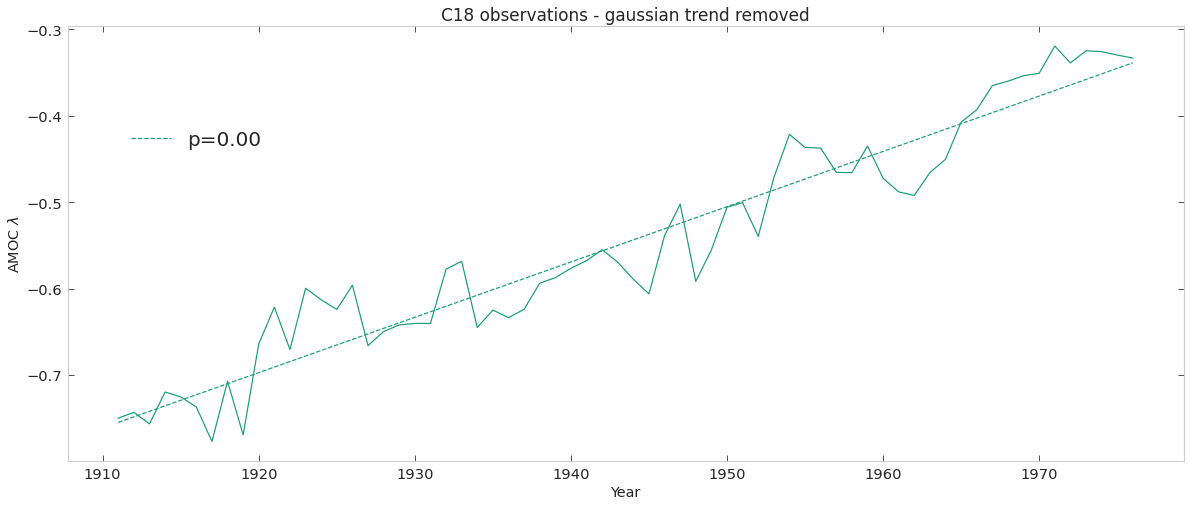

In [34]:
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
oyear=data2_c['year']
oindex=data2_c['AMOC proxy [K]']
otrend, intercept, r, p, se = linregress(oyear, oindex)


oamoc_low = gaussian_filter1d(oindex, 10)
lam = run_fit_a_ar1(np.array((oindex-oamoc_low)[5:-5]),70)
bound = 70 // 2
tt = oyear[5:-5][bound:-bound]
p0, p1 = np.polyfit(tt[:-2], lam[bound:-bound][:-2], 1)
pv = kendall_tau_test(lam[bound:-bound][:-2], 10000, p0)
o_lambda_trend = p0
o_lambda_pv = pv

slope, intercept, r, p, se = linregress(oyear, oindex)
o_trend = slope*100

%matplotlib inline
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)

ax.plot(oyear[5:-5],lam,color='C0')
ax.plot(tt,tt*p0+p1,linestyle='--',color='C0',label='p={:.2f}'.format(o_lambda_pv))
# plt.xlim(1880,2022)
ax.set_ylabel('AMOC $\lambda$')
ax.set_xlabel('Year')
ax.set_title('C18 observations - gaussian trend removed')
ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
plt.show()

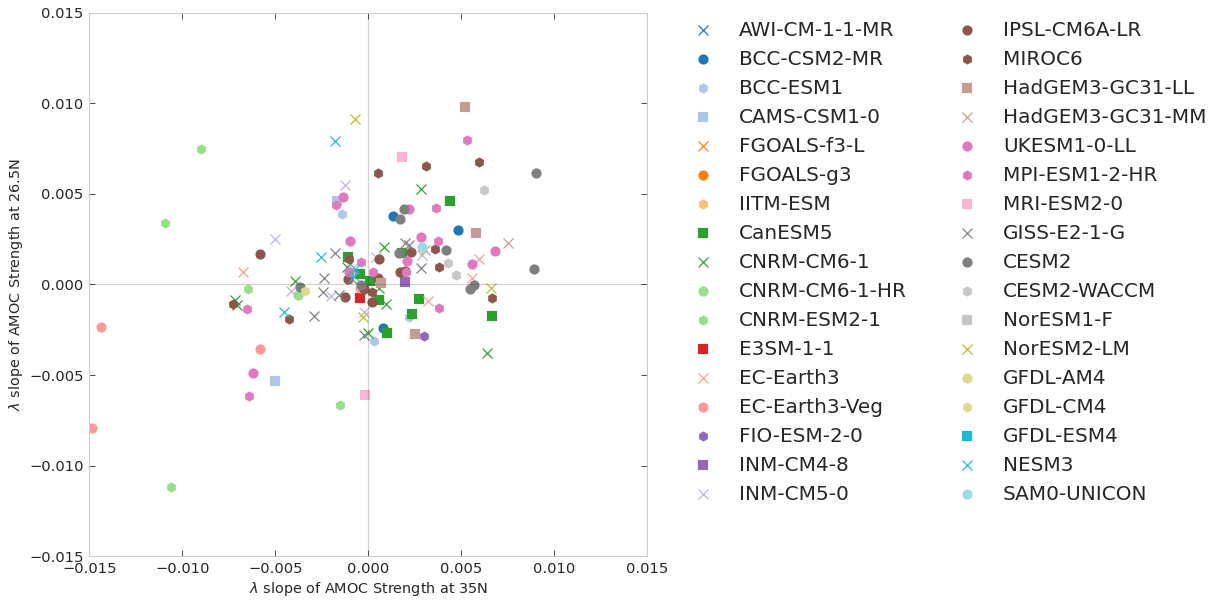

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(lambda_trends.strn35_trends.values[i],lambda_trends.strn26_trends.values[i],color=col,label=mod,marker=marker,s=100)
# plt.scatter(lambda_trends.index_trends.values,lambda_trends.strn26_trends.values)
# plt.vlines(o_lambda_trend,-0.02,0.02,color='k')
plt.ylim(-0.015,0.015)
# slope, intercept, r, p, se = linregress(np.nan_to_num(lambda_trends.strn35_trends.values.flatten()),np.nan_to_num(lambda_trends.strn26_trends.values.flatten()))
# xx = np.linspace(-0.02,0.03,100)
# plt.plot(xx,intercept+xx*slope,color='C0',linestyle='--',label='R = {:.2f}'.format(r))
ax.set_xlim(-0.015,0.015)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.ylabel('$\lambda$ slope of AMOC Strength at 26.5N')
plt.xlabel('$\lambda$ slope of AMOC Strength at 35N')
fig.patch.set_facecolor("white")
plt.show()
plt.show()

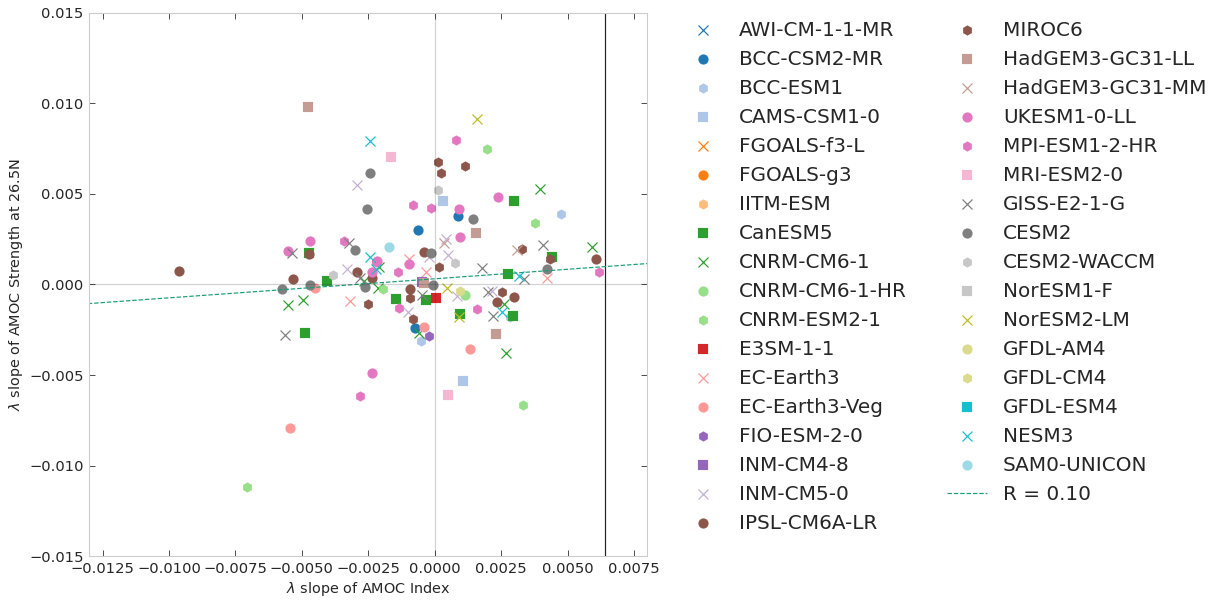

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(lambda_trends.index_trends.values[i],lambda_trends.strn26_trends.values[i],color=col,label=mod,marker=marker,s=100)
# plt.scatter(lambda_trends.index_trends.values,lambda_trends.strn26_trends.values)
plt.vlines(o_lambda_trend,-0.02,0.02,color='k')
plt.ylim(-0.015,0.015)
slope, intercept, r, p, se = linregress(np.nan_to_num(lambda_trends.index_trends.values.flatten()),np.nan_to_num(lambda_trends.strn26_trends.values.flatten()))
xx = np.linspace(-0.02,0.03,100)
plt.plot(xx,intercept+xx*slope,color='C0',linestyle='--',label='R = {:.2f}'.format(r))
ax.set_xlim(-0.013,0.008)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.ylabel('$\lambda$ slope of AMOC Strength at 26.5N')
plt.xlabel('$\lambda$ slope of AMOC Index')
plt.show()
plt.show()

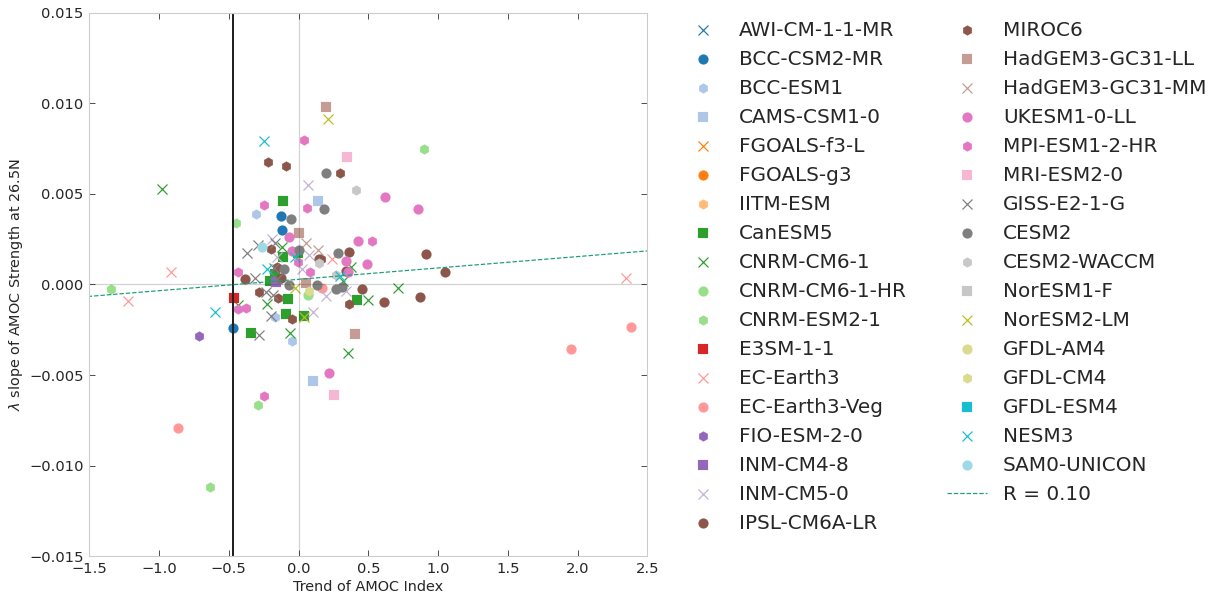

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(index_trend[i],lambda_trends.strn26_trends.values[i],color=col,label=mod,marker=marker,s=100)
# plt.scatter(index_trend,lambda_trends.strn26_trends.values,color='C1')
plt.vlines(o_trend,-0.02,0.02,color='k',lw=2)
plt.ylim(-0.015,0.015)
plt.xlim(-1.5,2.5)
plt.hlines(0,-10,10,color='k',alpha=0.2)
plt.vlines(0,-10,10,color='k',alpha=0.2)
idc = np.where(index_trend.flatten()<10)
slope, intercept, r, p, se = linregress(index_trend.flatten()[idc],np.nan_to_num(lambda_trends.strn26_trends.values.flatten()[idc]))
xx = np.linspace(-10,10,100)
plt.plot(xx,intercept+xx*slope,color='C0',linestyle='--',label='R = {:.2f}'.format(r))
# ax.set_ylim(-3.5,4)
# ax.set_xlim(-1.6,2.6)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.ylabel('$\lambda$ slope of AMOC Strength at 26.5N')
plt.xlabel('Trend of AMOC Index')
plt.show()
plt.show()